In [1]:
#Importing Libraries
import pandas as pd; import datetime as dt; import numpy as np; import matplotlib.pyplot as plt; import seaborn as sns
import warnings; import statsmodels.formula.api as sm; import holidays; import time; pd.options.mode.chained_assignment = None

C:\Users\malik\AppData\Local\Temp\ipykernel_55668\3636578027.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  drop_columns = ['Location','Commercial Flow']; df = df.drop(drop_columns, 1)


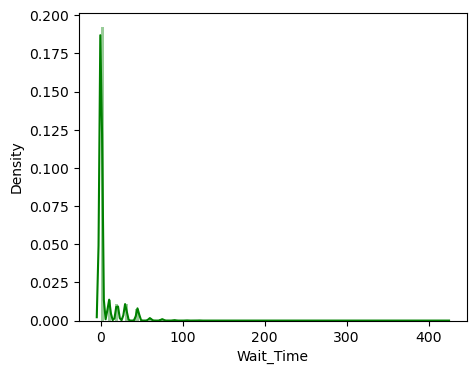

In [2]:
#Reading the data file
df = pd.read_csv(r'C:\Users\malik\OneDrive\Desktop\MS Business Analytics\bwt-taf-2010-2014-eng.csv')

#Extracing relevant data of Lewiston Bridge and resetting index
df = df[df['CBSA Office'].str.contains("Queenston-Lewiston Bridge")]; df.reset_index(drop=True, inplace=True)

#Dropping irrelavant columns
drop_columns = ['Location','Commercial Flow']; df = df.drop(drop_columns, 1)

#Replacing all No Delay Instances with 0 to represent 0 mins Delay
df['Travellers Flow'] = df['Travellers Flow'].replace('No Delay', 0, regex=True)
df['Travellers Flow'] = df['Travellers Flow'].astype(str)

#Removing all instances of Closed from dataset and converting the column type to integer
df = df[df["Travellers Flow"].str.contains("Closed")==False]
df['Travellers Flow'] = df['Travellers Flow'].astype(str).astype(int)

#Changing name of column to Wait_Time
df = df.rename(columns={'Travellers Flow': 'Wait_Time'})

warnings.filterwarnings('ignore'); plt.figure(figsize=(5, 4)); sns.distplot(df['Wait_Time'], color='g', bins=100, hist_kws={'alpha': 0.4})
plt.show()

In [3]:
#Removing Outliers
df.drop( df[ df['Wait_Time'] > 120 ].index, inplace=True); df['Wait_Time'].value_counts()

0      35675
10      2493
20      2043
30      1986
45      1455
60       294
75       171
90        53
105       20
120       16
Name: Wait_Time, dtype: int64

In [4]:
warnings.filterwarnings('ignore')
#Converting to date
df['Date'] = pd.to_datetime(df['Updated'], errors='ignore')

#Getting hours from datetime in 24 hour format
df['hour'] = df['Date'].dt.hour

#Determining if hour is in first 12 hours of day or in second 12 hours of the day
# 0 -> First part of day and 1 -> Second part of day
df['hours'] = [1 if val.hour > 12 else 0 for val in df['Date']]

#Returning weekday in form of integers (0-6 -> Monday-Sunday)
df['day'] = df['Date'].dt.weekday

#Determining if day is business day or weekend day
nonweekend=[0,1,2,3,4]
Weekday=[]
for i in range(len(df['Date'])):
    if df['day'].iloc[i] in nonweekend:
        Weekday.append(0) # 0 means business day
    else:
        Weekday.append(1) # 1 means weekend day
df['Weekday_or_Weekend'] = Weekday

#Extracting month from date column values
df['Months']= df['Date'].dt.month

#Determing if the day is a Holiday or not
US_Holidays = []; CA_Holidays = []; Yrs = [2010,2011,2012,2013,2014]
for date in holidays.UnitedStates(years=Yrs).items():
    US_Holidays.append(str(date[0]))
df['US_Holidays'] = [1 if str(val).split()[0] in US_Holidays else 0 for val in df['Date']]

for date in holidays.Canada(years=Yrs).items():
    CA_Holidays.append(str(date[0]))
df['CA_Holidays'] = [2 if str(val).split()[0] in CA_Holidays else 0 for val in df['Date']]

# In df['Holidays'] => 0 -> No Holiday, 1 -> US Holidays, 2 -> CA Holidays and 3 -> Common Holidays
df["Holidays"] = df["CA_Holidays"] + df["US_Holidays"]
df.drop( df[ df['Holidays'] == 1].index, inplace=True)
df.drop( df[ df['Holidays'] == 2].index, inplace=True)

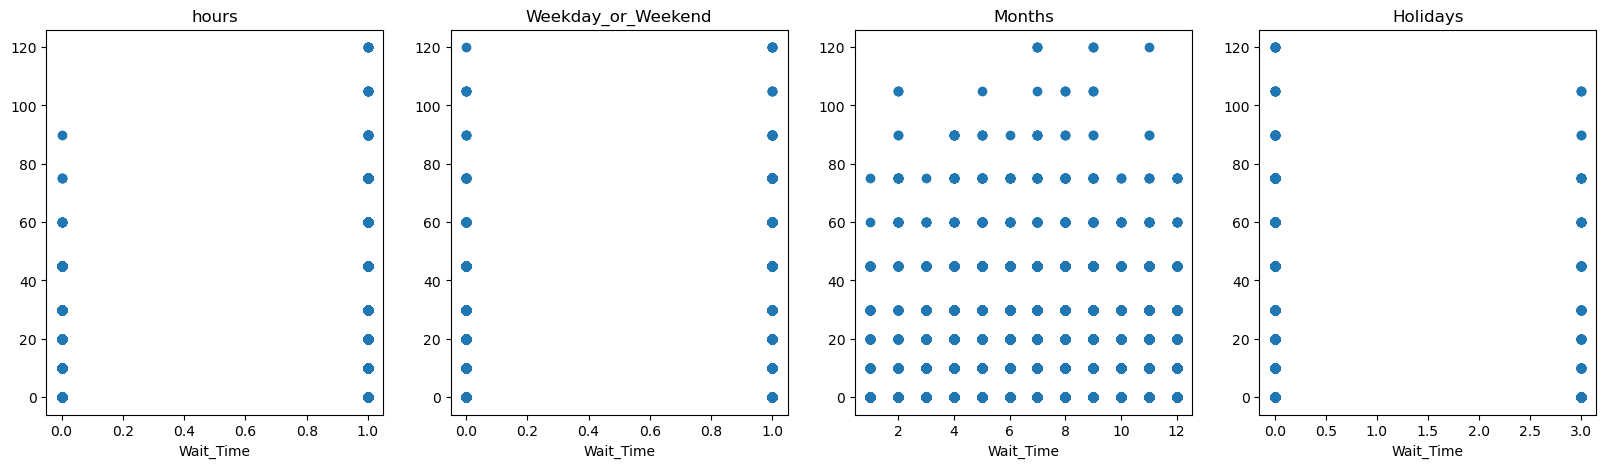

In [5]:
x_col = "Wait_Time"; y_columns = ["hours", "Weekday_or_Weekend", "Months", "Holidays"]
fig, ax = plt.subplots(1, len(y_columns), figsize = (20, 5))
for idx, col in enumerate(y_columns, 0):
    ax[idx].plot(df[col], df[x_col], 'o'); ax[idx].set_xlabel(x_col); ax[idx].set_title(col)
plt.show()

In [6]:
#Determining important months per the wait time
Months_with_high_waitTime=[2,5,7,8,9,11]
Months=[]
for i in range(len(df['Date'])):
    if df['Months'].iloc[i] in Months_with_high_waitTime:
        Months.append(1) # 1 means Months with higher wait times comparatively
    else:
        Months.append(0) # 0 means Months with lower wait times comparatively
df['Months'] = Months

In [7]:
#Dropping the now irelevant columns
drop_columns = ['CBSA Office','Updated','Date','hour','day','US_Holidays','CA_Holidays']
df = df.drop(drop_columns, 1)
df.head(2)

,Wait_Time,hours,Weekday_or_Weekend,Months,Holidays
0,0,1,0,0,0
1,0,0,0,0,0


In [8]:
df.corr()

,Wait_Time,hours,Weekday_or_Weekend,Months,Holidays
Wait_Time,1.000000,0.314314,0.173537,0.135028,0.042248
hours,0.314314,1.000000,0.005529,0.006212,0.004846
Weekday_or_Weekend,0.173537,0.005529,1.000000,-0.004190,-0.039063
Months,0.135028,0.006212,-0.004190,1.000000,-0.037033
Holidays,0.042248,0.004846,-0.039063,-0.037033,1.000000


In [9]:
OLS_result = sm.ols(formula="Wait_Time ~ C(hours)  + C(Weekday_or_Weekend) + C(Months) + C(Holidays)", data=df).fit()
OLS_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Wait_Time   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     1868.
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        01:57:03   Log-Likelihood:            -1.6504e+05
No. Observations:               42680   AIC:                         3.301e+05
Df Residuals:                   42675   BIC:                         3.301e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -1.9752      0.103    -19.245      0.000      -2.176      -1.774
C(hours)[T.1]                  7.8311      0.112     69.919      0.000       7.612       8.051
C(Weekday_or_Weekend)[T.1]     4.7770      0.122     39.030      0.000       4.537       5.017
C(Months)[T.1]                 3.4050      0.112     30.380      0.000       3.185       3.625
C(Holidays)[T.3]               5.1787      0.441     11.756      0.000       4.315       6.042
==============================================================================
Omnibus:                    23566.310   Durbin-Watson:                   0.463
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           203186.667
Skew:                           2.559   Prob(JB):                         0.00
Kurtosis:                      12.384   Cond. No.                         10.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
# Converting the Y variable -> Wait_Time into a binary categorical variable
Avg_Wait_Time=df["Wait_Time"].mean()

# calculating mean wait time
Wait_Time_categorical = [1 if val > Avg_Wait_Time else 0 for val in df["Wait_Time"]]

# 1 -> Wait time greater than average and 0 -> Wait time less than average
df.insert(1, 'Wait_Time_Categorical', Wait_Time_categorical)
df.head(2)

,Wait_Time,Wait_Time_Categorical,hours,Weekday_or_Weekend,Months,Holidays
0,0,0,1,0,0,0
1,0,0,0,0,0,0


In [11]:
Logistic_result=sm.logit(formula="Wait_Time_Categorical ~ hours + Weekday_or_Weekend + Months + C(Holidays)",data=df).fit()
Logistic_result.summary()

Optimization terminated successfully.
         Current function value: 0.400904
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Logit Regression Results                            
=================================================================================
Dep. Variable:     Wait_Time_Categorical   No. Observations:                42680
Model:                             Logit   Df Residuals:                    42675
Method:                              MLE   Df Model:                            4
Date:                   Thu, 30 Mar 2023   Pseudo R-squ.:                  0.1781
Time:                           01:57:18   Log-Likelihood:                -17111.
converged:                          True   LL-Null:                       -20818.
Covariance Type:               nonrobust   LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -3.6169      0.038    -95.972      0.000      -3.691      -3.543
C(Holidays)[T.3]       0.7063      0.097      7.288      0.000       0.516       0.896
hours                  2.1848      0.033     65.265      0.000       2.119       2.250
Weekday_or_Weekend     0.8990      0.028     31.846      0.000       0.844       0.954
Months                 0.8003      0.028     28.990      0.000       0.746       0.854
======================================================================================
"""